# Machine learning for image classification project

The goal of the project will be to build a functional, flexible and modular ML model in python for image classification as a practice.

## Scope: do build and optimize a machine learning model on a image classification task. 
As the project advances I hope to be able to investigate a bit the trade-offs between number of classes included, precision and the space of the hyperparameters that is searched.

## Import modules
I like to keep track of all modules used in the project by importing them on top

In [143]:
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
from skimage.feature import hog
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin
from joblib import Parallel, delayed, dump, load
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from IPython.display import display

## Loading and preparing the dataset

I will be using the [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html) dataset.
For more info check Chapter 3 of this tech report:
- [Learning Multiple Layers of Features from Tiny Images](https://www.cs.toronto.edu/~kriz/learning-features-2009-TR.pdf), Alex Krizhevsky, 2009.

The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.

The dataset is divided into five training batches and one test batch, each with 10000 images. The test batch contains exactly 1000 randomly-selected images from each class. The training batches contain the remaining images in random order, but some training batches may contain more images from one class than another. Between them, the training batches contain exactly 5000 images from each class. 

First I will define some functions to load and reshape the data as needed. Then I will load the dataset, leaving flexibility for the amount of batches loaded. I shal plot some images to check that de data was loaded correctly.

Loading the test data will only be done after training the model.

In [135]:
# This code is for the pickled version of the data, prepared for Python

# Change this according to your needs
path_to_data = r"../cifar-10-batches-py/"

class Training_data():
    """
    Class to load and hold the training data that we want.
    """
    def __init__(self, path, batches):
        """
        Get the path, the batches we want to load, and call the loading routine for each batch
        Also, Load the dict to convert label to human readable.
        """
        self.path = path
        self.batches = batches
        self.loadnames()
        for batch in batches:
            if batch == batches[0]:
                self.data, self.labels = self.load(batch)
            else:
                new_data, new_labels = self.load(batch)
                self.data = np.row_stack((self.data, new_data))
                self.labels += new_labels
            
    def load(self, batch):
        """
        Load the batch file, and return the data structured.
        """
        file = self.path + "data_batch_" + str(batch)
        batch_file = self.unpickle(file)
        return self.structure(batch_file[b'data'], batch_file[b'labels'])
        
    def unpickle(self, file):
        """
        Method to load the pickled version of the dataset.
        """
        with open(file, "rb") as fo:
            im_dict = pickle.load(fo, encoding = "bytes")
        return im_dict
    
    def structure(self, data, labels):
        """
        Reshape the 1D image data to the correct shape for image viewing with matplotlib
        """
        data = np.reshape(data, (-1, 3, 32, 32))
        data = np.transpose(data, (0, 2, 3, 1))
        return data, labels
    
    def loadnames(self):
        labeldict = self.unpickle(self.path + "batches.meta")
        self.labelnames = {}
        for i in range(10):
            self.labelnames[i] = labeldict[b'label_names'][i].decode()

Now use the defined class to load the data

In [3]:
training_data = Training_data(path_to_data, [1])

Show the image for a given datapoint, and plot the human readable label to check if the provided data makes sense

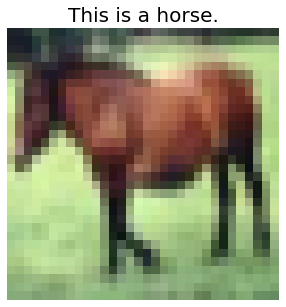

In [26]:
# Insert datapoint here
datapoint = 7

# Plot and add label as title
plt.figure(figsize = (5, 5))
plt.imshow(training_data.data[datapoint])
plt.title("This is a " + training_data.labelnames[training_data.labels[datapoint]] + ".", fontsize = 20)
plt.axis('off')
plt.show()

## Feature engineering
Just blindly fitting a model might not work, or take very long to train.
Some reduction of the size of the dataset before fitting would come in handy.

As we are working with images, one of the most common reduction methods is going for a historgam of oriented gradients (HOG).
scikit-image has a provision for that.

Again, we will try to plot what we are doing with the data.

First, check what our HOG does to our previously plotted datapoint, and the remaining feature size.

Remember the full picture is 32×32×3 = 3072

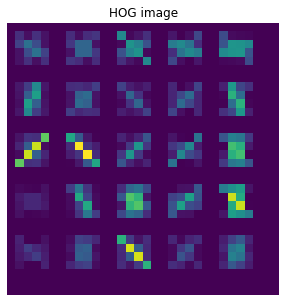

The new feature size is 512 points.


In [100]:
hog_options = {"pixels_per_cell" : (6,6),
               "cells_per_block" : (2, 2),
               "orientations" : 8,
               "block_norm" : 'L2-Hys',
               "visualize" : True, # For our example we want to see what we do
               "channel_axis" : -1
               }

data_hog, data_im = hog(training_data.data[datapoint], **hog_options)

plt.figure(figsize = (5, 5))
plt.title("HOG image")
plt.imshow(data_im)
plt.axis('off')
plt.show()
print("The new feature size is {} points.".format(data_hog.size))

## Creating a pipeline
Now we create a pipeline that incorporates all preprocessing and model steps that we can later fine-tune

First we need a new class for our HOG Transformer.

Joblib is used to parallelize the HOG calculation for speedup.

In [101]:
class HogTransformer(BaseEstimator, TransformerMixin):
    """
    Expexts an array of RGB images
    Calculates HOG for each image
    For options see hog from scikit-image
    """
    def __init__(self, pixels_per_cell = (7,7), cells_per_block = (2, 2), orientations = 8, block_norm = "L2-Hys",
                  channel_axis = -1, jobs = 4):
        self.pixels_per_cell = pixels_per_cell
        self.cells_per_block = cells_per_block
        self.orientations = orientations
        self.block_norm = block_norm
        self.channel_axis = channel_axis
        self.jobs = jobs
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        local_hog_options = {"pixels_per_cell" : self.pixels_per_cell,
               "cells_per_block" : self.cells_per_block,
               "orientations" : self.orientations,
               "block_norm" : self.block_norm,
               "visualize" : False,
               "channel_axis" : self.channel_axis
               }
        return np.array(Parallel(n_jobs=self.jobs)(delayed(hog)(i, **local_hog_options) for i in X))
        

Now we can create our pipeline for the image clasification problem.

HogTransform -> Scaler -> SVM

To speed up things a SGD SVM is used for now

In [102]:
image_pipeline = Pipeline([("transformer", HogTransformer(jobs = 6)), 
                           ("scaler", StandardScaler()), 
                           ("classifier", SGDClassifier(n_jobs = 6, max_iter = 10000))])

In [103]:
image_pipeline.fit(training_data.data, training_data.labels)

Pipeline(steps=[('transformer', HogTransformer(jobs=6)),
                ('scaler', StandardScaler()),
                ('classifier', SGDClassifier(max_iter=10000, n_jobs=6))])

## Testing the model
Here we'll load the test data, and run some test before optimizing the model

In [104]:
class Test_Data(Training_data):
    """
    Based on loading training data, but overwride some methods due to different fiole structure
    """
    def __init__(self, path):
        """
        Get the path, the batches we want to load, and call the loading routine for each batch
        Also, Load the dict to convert label to human readable.
        """
        self.path = path
        self.data, self.labels = self.load()
        
    def load(self):
        """
        Load the batch file, and return the data structured.
        """
        file = self.path + "test_batch"
        test_file = self.unpickle(file)
        return self.structure(test_file[b'data'], test_file[b'labels'])

In [105]:
test_data = Test_Data(path_to_data)

Now we can score the not optimized model:

In [106]:
init_score = image_pipeline.score(test_data.data, test_data.labels)
print("Score of the model as is is: {}.".format(init_score))

Score of the model as is is: 0.4004.


## Optimizing the model
Using scikit-learns GridSearchCV, RandomizedSearchCV to optimize parameters

Start by defining a search space of the relevant parameters:

In [107]:
search_space = {"transformer__pixels_per_cell" : [(5,5), (6,6), (7,7), (8,8)],
                "transformer__cells_per_block" : [(2, 2), (3,3), (4,4)],
                "transformer__orientations" : [6,7,8,9],
                "transformer__block_norm" : ["L1", "L1-sqrt", "L2", "L2-Hys"],
                "classifier__alpha" : np.geomspace(0.0001, 100, 7)}

As there are loads of parameters, create a randomized search

In [108]:
rscv = RandomizedSearchCV(image_pipeline, search_space, n_iter = 50)

Now do the optimization of the hyperparameters of the pipeline

In [109]:
rscv.fit(training_data.data, training_data.labels)

RandomizedSearchCV(estimator=Pipeline(steps=[('transformer',
                                              HogTransformer(jobs=6)),
                                             ('scaler', StandardScaler()),
                                             ('classifier',
                                              SGDClassifier(max_iter=10000,
                                                            n_jobs=6))]),
                   n_iter=50,
                   param_distributions={'classifier__alpha': array([1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02]),
                                        'transformer__block_norm': ['L1',
                                                                    'L1-sqrt',
                                                                    'L2',
                                                                    'L2-Hys'],
                                        'transformer__cells_per_block': [(2, 2),
                                        

As optimization takes a long time: save the results to an external file

In [116]:
filename = "rscv_result.joblib"
dump(rscv, filename)



['rscv_result.joblib']

### Now let's analise the optimization results

First, check the parameters of the best model

In [124]:
print(rscv.best_estimator_)

Pipeline(steps=[('transformer',
                 HogTransformer(block_norm='L2', jobs=6,
                                pixels_per_cell=(6, 6))),
                ('scaler', StandardScaler()),
                ('classifier',
                 SGDClassifier(alpha=0.1, max_iter=10000, n_jobs=6))])


Now see if we can learn something of the best 10 models

In [125]:
# Create and display Pandas DataFrame
df = pd.concat([pd.DataFrame(rscv.cv_results_['params']), pd.DataFrame(rscv.cv_results_['mean_test_score'], columns=['Accuracy'])], axis=1)
cv_table = df.sort_values("Accuracy", ascending = False)
display(cv_table.head(10))

,transformer__pixels_per_cell,transformer__orientations,transformer__cells_per_block,transformer__block_norm,classifier__alpha,Accuracy
34,"(6, 6)",8,"(2, 2)",L2,0.10,0.4987
2,"(6, 6)",8,"(4, 4)",L2,0.01,0.4902
22,"(5, 5)",7,"(4, 4)",L1-sqrt,0.10,0.4891
16,"(6, 6)",8,"(3, 3)",L1-sqrt,0.10,0.4886
10,"(6, 6)",6,"(3, 3)",L1-sqrt,0.01,0.4828
12,"(8, 8)",7,"(3, 3)",L2-Hys,0.10,0.4824
7,"(6, 6)",6,"(4, 4)",L1-sqrt,0.10,0.4813
29,"(5, 5)",9,"(3, 3)",L2-Hys,1.00,0.4774
46,"(5, 5)",7,"(4, 4)",L1-sqrt,1.00,0.4772
21,"(6, 6)",9,"(3, 3)",L2,1.00,0.4722


And how does the model score on the test data:

In [112]:
cv_score = rscv.score(test_data.data, test_data.labels)
print("Score of the optimized model is: {}.".format(cv_score))

Score of the optimized model is: 0.5045.


## Fitting model on full dataset
I optimized on a reduced portion in order to speed up optimization time

In [140]:
training_data_full = Training_data(path_to_data, [1, 2, 3, 4, 5])
optimized_pipeline = rscv.best_estimator_

In [141]:
optimized_pipeline.fit(training_data_full.data, training_data_full.labels)

Pipeline(steps=[('transformer',
                 HogTransformer(block_norm='L2', jobs=6,
                                pixels_per_cell=(6, 6))),
                ('scaler', StandardScaler()),
                ('classifier',
                 SGDClassifier(alpha=0.1, max_iter=10000, n_jobs=6))])

In [142]:
full_score = optimized_pipeline.score(test_data.data, test_data.labels)
print("Score of the optimized model trained on the full dataset is: {}.".format(cv_score))

Score of the optimized model trained on the full dataset is: 0.5045.


## More analysis
50% score with 10 classes is better than random guess. But where do we go wrong.
Let's create a confusion matrix to see if there are some obvious issues

              precision    recall  f1-score   support

    airplane       0.58      0.57      0.58      1000
  automobile       0.58      0.63      0.60      1000
        bird       0.43      0.36      0.39      1000
         cat       0.42      0.26      0.32      1000
        deer       0.46      0.40      0.43      1000
         dog       0.45      0.41      0.43      1000
        frog       0.51      0.69      0.59      1000
       horse       0.48      0.62      0.54      1000
        ship       0.60      0.50      0.54      1000
       truck       0.58      0.71      0.64      1000

    accuracy                           0.52     10000
   macro avg       0.51      0.52      0.51     10000
weighted avg       0.51      0.52      0.51     10000



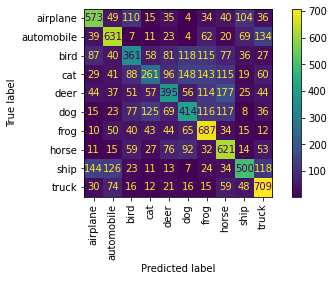

In [149]:
y_pred = optimized_pipeline.predict(test_data.data)
labels = list(training_data_full.labelnames.values())
print(classification_report(test_data.labels, y_pred, target_names=labels))
ConfusionMatrixDisplay.from_estimator(
    optimized_pipeline, test_data.data, test_data.labels, display_labels=labels, xticks_rotation="vertical"
)
plt.tight_layout()
plt.show()

## Conclusion

It seems that the pipeline developped here works reasonably for the identification of images of a few classes. E.g., especially trucks are well recognized. However, some other categories give problems.

Using a SGD SVM classifier was always going to be a bit optimistic with image recognition. However, combining it with the HOG transform, we got a pipeline that we could optimize on a simple laptop which gives results that are much better than random guesses.

Future seps can involve improving the pre-processor (HOG-PCA comes to mind), or working on an aggregation of estimators.
However, it is probably best for me to start learning more about neural networks for image recognition.